In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('722_I4').getOrCreate()
from pyspark.sql.functions import mean,when
from pyspark.sql.functions import count, col, desc
from pyspark.sql.functions import sum as spark_sum
from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.functions import vector_to_array

import pandas as pd
import matplotlib.pyplot as plt

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 14:49:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df1 = spark.read.csv('Diabetes_1.csv', inferSchema=True, header=True)
df1.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)



In [4]:
df2 = spark.read.csv('Diabetes_2.csv', inferSchema=True, header=True)
df2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [5]:
df2 = df2.drop('blood_glucose_level', 'HbA1c_level')
df2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- diabetes: integer (nullable = true)



In [6]:
missing_counts = df1.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])
missing_counts.show()
missing_counts = df2.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df2.columns])
missing_counts.show()
avg_val = df1.agg(mean(df1['age'])).first()[0]
df1 = df1.fillna({'age': avg_val})
mode_val = df1.groupBy('gender').agg(count('gender').alias('count')).orderBy(desc('count')).first()[0]
df1 = df1.fillna({'gender': mode_val})

avg_val = df2.agg(mean(df2['hypertension'])).first()[0]
df2 = df2.fillna({'hypertension': avg_val})
avg_val = df2.agg(mean(df2['heart_disease'])).first()[0]
df2 = df2.fillna({'heart_disease': avg_val})
avg_val = df2.agg(mean(df2['bmi'])).first()[0]
df2 = df2.fillna({'bmi': avg_val})
avg_val = df2.agg(mean(df2['diabetes'])).first()[0]
df2 = df2.fillna({'diabetes': avg_val})
mode_val = df2.groupBy('smoking_history').agg(count('smoking_history').alias('count')).orderBy(desc('count')).first()[0]
df2 = df2.fillna({'smoking_history': mode_val})

print("Number of entries: ", df1.count())
print("Number of entries: ", df2.count())
missing_counts = df1.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])
missing_counts.show()
missing_counts = df2.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df2.columns])
missing_counts.show()

+---+------+---+
| ID|gender|age|
+---+------+---+
|  0|   164|157|
+---+------+---+

+---+------------+-------------+---------------+---+--------+
| ID|hypertension|heart_disease|smoking_history|bmi|diabetes|
+---+------------+-------------+---------------+---+--------+
|  0|         161|           95|            253|160|     184|
+---+------------+-------------+---------------+---+--------+

Number of entries:  100000
Number of entries:  100000
+---+------+---+
| ID|gender|age|
+---+------+---+
|  0|     0|  0|
+---+------+---+

+---+------------+-------------+---------------+---+--------+
| ID|hypertension|heart_disease|smoking_history|bmi|diabetes|
+---+------------+-------------+---------------+---+--------+
|  0|           0|            0|              0|  0|       0|
+---+------------+-------------+---------------+---+--------+



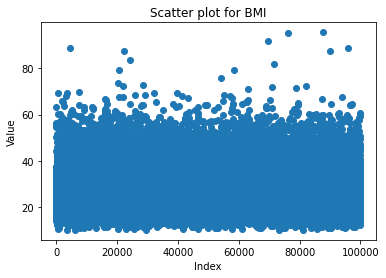

In [7]:

df2 = df2.filter((df2.bmi <= 100) & (df2.bmi >= 0))
df_pd = df2.toPandas()
plt.scatter(range(len(df_pd['bmi'])), df_pd['bmi'])
plt.title('Scatter plot for BMI')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [8]:
df = df1.join(df2, 'id', 'inner')
df.printSchema()
print("Number of entries: ", df.count())

root
 |-- ID: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- age: double (nullable = false)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = false)
 |-- bmi: double (nullable = false)
 |-- diabetes: integer (nullable = true)

Number of entries:  99998


In [9]:
age_bins = [0, 2, 4, 13, 20, 30, 50, 65, 81]
age_labels = ["Infants", "Toddlers", "Children", "Teenagers", "Young", "Middle-aged", "Older adults", "Seniors"]

age_column_expr = when(col("age") < age_bins[0], None)  
for i in range(len(age_bins) - 1):
    age_column_expr = age_column_expr.when((col("age") >= age_bins[i]) & (col("age") < age_bins[i + 1]), age_labels[i])

df = df.withColumn("Age group", age_column_expr)

bmi_bins = [0, 18.50, 24.99, 29.99, 34.99, 39.99, 100]
bmi_labels = ["Underweight", "Normal weight", "Overweight", "Obesity I", "Obesity II", "Obesity III"]

bmi_column_expr = when(col("bmi") < bmi_bins[0], None)  
for i in range(len(bmi_bins) - 1):
    bmi_column_expr = bmi_column_expr.when((col("bmi") >= bmi_bins[i]) & (col("bmi") < bmi_bins[i + 1]), bmi_labels[i])

df = df.withColumn("Bmi class", bmi_column_expr)
df.show()

+---+------+----+------------+-------------+---------------+-----+--------+------------+-------------+
| ID|gender| age|hypertension|heart_disease|smoking_history|  bmi|diabetes|   Age group|    Bmi class|
+---+------+----+------------+-------------+---------------+-----+--------+------------+-------------+
|  1|Female|80.0|           0|            1|          never|25.19|       0|     Seniors|   Overweight|
|  2|Female|54.0|           0|            0|        No Info|27.32|       0|Older adults|   Overweight|
|  3|  Male|28.0|           0|            0|          never|27.32|       0|       Young|   Overweight|
|  4|Female|36.0|           0|            0|        current|23.45|       0| Middle-aged|Normal weight|
|  5|  Male|76.0|           1|            1|        current|20.14|       0|     Seniors|Normal weight|
|  6|Female|20.0|           0|            0|          never|27.32|       0|       Young|   Overweight|
|  7|Female|44.0|           0|            0|          never|19.31|       

In [10]:
medical_features = ['hypertension', 'heart_disease']

df = df.withColumn("Medical_History_Count", sum(col(feature) for feature in medical_features))
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- age: double (nullable = false)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = false)
 |-- bmi: double (nullable = false)
 |-- diabetes: integer (nullable = true)
 |-- Age group: string (nullable = true)
 |-- Bmi class: string (nullable = true)
 |-- Medical_History_Count: integer (nullable = true)



In [11]:
indexer = StringIndexer(inputCol="Age group", outputCol="Age group_index")
indexed_model = indexer.fit(df)
df = indexed_model.transform(df)
labels = indexed_model.labels
encoder = OneHotEncoder(inputCols=["Age group_index"], outputCols=["Age group_encoded"], dropLast=False)
df = encoder.fit(df).transform(df)
num_categories_age = df.select("Age group_index").distinct().count()
df = df.withColumn("Age group_array", vector_to_array("Age group_encoded"))
for i, label in enumerate(labels):
    df = df.withColumn(f"Age group_{label}", col("Age group_array")[i].cast("int"))

indexer = StringIndexer(inputCol="Bmi class", outputCol="Bmi class_index")
indexed_model = indexer.fit(df)
df = indexed_model.transform(df)
labels = indexed_model.labels
encoder = OneHotEncoder(inputCols=["Bmi class_index"], outputCols=["Bmi class_encoded"], dropLast=False)
df = encoder.fit(df).transform(df)
num_categories_bmi = df.select("Bmi class_index").distinct().count()
df = df.withColumn("Bmi class_array", vector_to_array("Bmi class_encoded"))
for i, label in enumerate(labels):
    df = df.withColumn(f"Bmi class_{label}", col("Bmi class_array")[i].cast("int"))


indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
indexed_model = indexer.fit(df)
df = indexed_model.transform(df)
labels = indexed_model.labels
encoder = OneHotEncoder(inputCols=["gender_index"], outputCols=["gender_encoded"], dropLast=False)
df = encoder.fit(df).transform(df)
num_categories_gender = df.select("gender_index").distinct().count()
df = df.withColumn("gender_array", vector_to_array("gender_encoded"))
for i, label in enumerate(labels):
    df = df.withColumn(f"gender_{label}", col("gender_array")[i].cast("int"))

indexer = StringIndexer(inputCol="smoking_history", outputCol="smoking_history_index")
indexed_model = indexer.fit(df)
df = indexed_model.transform(df)
labels = indexed_model.labels
encoder = OneHotEncoder(inputCols=["smoking_history_index"], outputCols=["smoking_history_encoded"], dropLast=False)
df = encoder.fit(df).transform(df)
num_categories_smoking = df.select("smoking_history_index").distinct().count()
df = df.withColumn("smoking_history_array", vector_to_array("smoking_history_encoded"))
for i, label in enumerate(labels):
    df = df.withColumn(f"smoking_history_{label}", col("smoking_history_array")[i].cast("int"))

indexer = StringIndexer(inputCol="Medical_History_Count", outputCol="Medical_History_Count_index")
indexed_model = indexer.fit(df)
df = indexed_model.transform(df)
labels = indexed_model.labels
encoder = OneHotEncoder(inputCols=["Medical_History_Count_index"], outputCols=["Medical_History_Count_encoded"], dropLast=False)
df = encoder.fit(df).transform(df)
num_categories_medical = df.select("Medical_History_Count_index").distinct().count()
df = df.withColumn("Medical_History_Count_array", vector_to_array("Medical_History_Count_encoded"))
for i, label in enumerate(labels):
    df = df.withColumn(f"Medical_History_Count_{label}", col("Medical_History_Count_array")[i].cast("int"))

columns_to_drop = ["Age group_index", "Bmi class_index", "gender_index", "smoking_history_index", 
                   "Medical_History_Count_index", "Age group_encoded", "Bmi class_encoded", 
                   "gender_encoded", "smoking_history_encoded", "Medical_History_Count_encoded", 
                   "Age group_array", "Bmi class_array", "gender_array", "smoking_history_array", 
                   "Medical_History_Count_array"]
df = df.drop(*columns_to_drop)


In [12]:

columns_to_keep = ['hypertension','heart_disease','diabetes','Age group_Middle-aged','Age group_Older adults',
                   'Age group_Seniors','Age group_Young','Age group_Children','Age group_Teenagers','Age group_Toddlers',
                   'Age group_Infants','Bmi class_Overweight','Bmi class_Normal weight','Bmi class_Obesity I',
                   'Bmi class_Underweight','Bmi class_Obesity II','Bmi class_Obesity III', 'gender_Female','gender_Male',
                   'gender_Other', 'smoking_history_never','smoking_history_former','smoking_history_current','smoking_history_not current',
                   'smoking_history_ever','Medical_History_Count_0','Medical_History_Count_1','Medical_History_Count_2'
]

df = df.select(columns_to_keep)

['hypertension',
 'heart_disease',
 'diabetes',
 'Age group_Middle-aged',
 'Age group_Older adults',
 'Age group_Seniors',
 'Age group_Young',
 'Age group_Children',
 'Age group_Teenagers',
 'Age group_Toddlers',
 'Age group_Infants',
 'Bmi class_Overweight',
 'Bmi class_Normal weight',
 'Bmi class_Obesity I',
 'Bmi class_Underweight',
 'Bmi class_Obesity II',
 'Bmi class_Obesity III',
 'gender_Female',
 'gender_Male',
 'gender_Other',
 'smoking_history_never',
 'smoking_history_former',
 'smoking_history_current',
 'smoking_history_not current',
 'smoking_history_ever',
 'Medical_History_Count_0',
 'Medical_History_Count_1',
 'Medical_History_Count_2']

In [13]:
df_select = df2[df2['smoking_history'] != 'No Info']
print("Number of entries: ", df_select.count())


Number of entries:  64104


28

In [14]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

input_columns = [col for col in df.columns if col != 'diabetes']
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
data = assembler.transform(df)

x = data.select("features")
y = data.select("diabetes")

clf = RandomForestClassifier(numTrees=100, labelCol="diabetes", featuresCol="features")
model = clf.fit(data)

importances = model.featureImportances
feature_importance = dict(zip(input_columns, importances))

sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Medical_History_Count_0: 0.2750476354896274
Age group_Seniors: 0.17294872490098095
Medical_History_Count_1: 0.14795701319936586
hypertension: 0.10347371551209998
heart_disease: 0.09786833183230986
Bmi class_Obesity III: 0.08103409985874106
Bmi class_Obesity II: 0.03804773812698891
Age group_Older adults: 0.025147386713881725
smoking_history_former: 0.010146766125788466
Age group_Young: 0.009788379968807376
Bmi class_Overweight: 0.009620969462939102
Medical_History_Count_2: 0.006724199316328204
Bmi class_Obesity I: 0.004356718484000921
Age group_Middle-aged: 0.004088431554412919
Age group_Children: 0.003801014732248373
Bmi class_Normal weight: 0.0032395955524961075
Bmi class_Underweight: 0.0015066370714340131
gender_Female: 0.0009839309075166326
Age group_Teenagers: 0.0009380200689783458
gender_Male: 0.0008020634411625231
smoking_history_not current: 0.0007759375168484241
smoking_history_never: 0.000627083241138104
smoking_history_current: 0.0005698610912972863
smoking_history_ever: 0.0

In [15]:
non_important_features = ['Age group_Toddlers', 'Age group_Infants', 'gender_Other']
for feature in non_important_features:
    df = df.drop(feature)
df.columns

['hypertension',
 'heart_disease',
 'diabetes',
 'Age group_Middle-aged',
 'Age group_Older adults',
 'Age group_Seniors',
 'Age group_Young',
 'Age group_Children',
 'Age group_Teenagers',
 'Bmi class_Overweight',
 'Bmi class_Normal weight',
 'Bmi class_Obesity I',
 'Bmi class_Underweight',
 'Bmi class_Obesity II',
 'Bmi class_Obesity III',
 'gender_Female',
 'gender_Male',
 'smoking_history_never',
 'smoking_history_former',
 'smoking_history_current',
 'smoking_history_not current',
 'smoking_history_ever',
 'Medical_History_Count_0',
 'Medical_History_Count_1',
 'Medical_History_Count_2']

In [48]:
diabetes_counts = df.groupBy('diabetes').count().collect()
print({row['diabetes']: row['count'] for row in diabetes_counts})

df_high = df.filter(col('diabetes') == 0)
df_low = df.filter(col('diabetes') == 1)
fraction = df_low.count() / df_high.count()
df_high_reduce = df_high.sample(False, fraction)
df_reduced = df_low.union(df_high_reduce)

reduced_diabetes_counts = df_reduced.groupBy('diabetes').count().collect()
print({row['diabetes']: row['count'] for row in reduced_diabetes_counts})


{0.0: 91503, 1.0: 8495}
{1.0: 8495, 0.0: 8441}
+--------+-----+
|diabetes|count|
+--------+-----+
|     1.0| 8495|
|     0.0| 8441|
+--------+-----+



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import DecisionTreeClassifier

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data, test_data = df_reduced.randomSplit([0.8, 0.2], seed=42)

dt_classifier = DecisionTreeClassifier(labelCol="diabetes", featuresCol="features")
pipeline = Pipeline(stages=[assembler, dt_classifier])
dt_model = pipeline.fit(train_data)
predictions_dt = dt_model.transform(test_data)

accuracy_dt = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy").evaluate(predictions_dt)
print(f"Decision Tree - Accuracy: {accuracy_dt:.4f}")

predictionLabels_dt = predictions_dt.select("prediction", "diabetes").rdd
metrics_dt = MulticlassMetrics(predictionLabels_dt)

precision_0_dt = metrics_dt.precision(label=0.0)
recall_0_dt = metrics_dt.recall(label=0.0)
f1Score_0_dt = metrics_dt.fMeasure(label=0.0)
precision_1_dt = metrics_dt.precision(label=1.0)
recall_1_dt = metrics_dt.recall(label=1.0)
f1Score_1_dt = metrics_dt.fMeasure(label=1.0)

print(f"Decision Tree - 0 - Precision: {precision_0_dt:.4f}")
print(f"Decision Tree - 0 - Recall: {recall_0_dt:.4f}")
print(f"Decision Tree - 0 - F1 Score: {f1Score_0_dt:.4f}")
print(f"Decision Tree - 1 - Precision: {precision_1_dt:.4f}")
print(f"Decision Tree - 1 - Recall: {recall_1_dt:.4f}")
print(f"Decision Tree - 1 - F1 Score: {f1Score_1_dt:.4f}")


Decision Tree - Accuracy: 0.7372


In [54]:
from pyspark.ml.classification import RandomForestClassifier

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data, test_data = df_reduced.randomSplit([0.8, 0.2], seed=42)

rf_classifier = RandomForestClassifier(labelCol="diabetes", featuresCol="features")
pipeline = Pipeline(stages=[assembler, rf_classifier])
rf_model = pipeline.fit(train_data)

predictions_rf = rf_model.transform(test_data)

accuracy_rf = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy").evaluate(predictions_rf)
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")

predictionLabels_rf = predictions_rf.select("prediction", "diabetes").rdd
metrics_rf = MulticlassMetrics(predictionLabels_rf)

precision_0_rf = metrics_rf.precision(label=0.0)
recall_0_rf = metrics_rf.recall(label=0.0)
f1Score_0_rf = metrics_rf.fMeasure(label=0.0)
precision_1_rf = metrics_rf.precision(label=1.0)
recall_1_rf = metrics_rf.recall(label=1.0)
f1Score_1_rf = metrics_rf.fMeasure(label=1.0)

print(f"Random Forest - 0 - Precision: {precision_0_rf:.4f}")
print(f"Random Forest - 0 - Recall: {recall_0_rf:.4f}")
print(f"Random Forest - 0 - F1 Score: {f1Score_0_rf:.4f}")
print(f"Random Forest - 1 - Precision: {precision_1_rf:.4f}")
print(f"Random Forest - 1 - Recall: {recall_1_rf:.4f}")
print(f"Random Forest - 1 - F1 Score: {f1Score_1_rf:.4f}")


Random Forest - Accuracy: 0.7469


Random Forest - 0 - Precision: 0.7570
Random Forest - 0 - Recall: 0.7338
Random Forest - 0 - F1 Score: 0.7452
Random Forest - 1 - Precision: 0.7373
Random Forest - 1 - Recall: 0.7602
Random Forest - 1 - F1 Score: 0.7486


In [55]:
from pyspark.ml.classification import GBTClassifier

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data, test_data = df_reduced.randomSplit([0.8, 0.2], seed=42)

gbt_classifier = GBTClassifier(labelCol="diabetes", featuresCol="features")
pipeline = Pipeline(stages=[assembler, gbt_classifier])
gbt_model = pipeline.fit(train_data)

predictions_gbt = gbt_model.transform(test_data)

accuracy_gbt = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy").evaluate(predictions_gbt)
print(f"Gradient Boosted Trees - Accuracy: {accuracy_gbt:.4f}")

predictionLabels_gbt = predictions_gbt.select("prediction", "diabetes").rdd
metrics_gbt = MulticlassMetrics(predictionLabels_gbt)

precision_0_gbt = metrics_gbt.precision(label=0.0)
recall_0_gbt = metrics_gbt.recall(label=0.0)
f1Score_0_gbt = metrics_gbt.fMeasure(label=0.0)
precision_1_gbt = metrics_gbt.precision(label=1.0)
recall_1_gbt = metrics_gbt.recall(label=1.0)
f1Score_1_gbt = metrics_gbt.fMeasure(label=1.0)

print(f"Gradient Boosted Trees - 0 - Precision: {precision_0_gbt:.4f}")
print(f"Gradient Boosted Trees - 0 - Recall: {recall_0_gbt:.4f}")
print(f"Gradient Boosted Trees - 0 - F1 Score: {f1Score_0_gbt:.4f}")
print(f"Gradient Boosted Trees - 1 - Precision: {precision_1_gbt:.4f}")
print(f"Gradient Boosted Trees - 1 - Recall: {recall_1_gbt:.4f}")
print(f"Gradient Boosted Trees - 1 - F1 Score: {f1Score_1_gbt:.4f}")


23/10/08 16:10:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/08 16:10:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Gradient Boosted Trees - Accuracy: 0.7563


Gradient Boosted Trees - 0 - Precision: 0.7773
Gradient Boosted Trees - 0 - Recall: 0.7242
Gradient Boosted Trees - 0 - F1 Score: 0.7498
Gradient Boosted Trees - 1 - Precision: 0.7376
Gradient Boosted Trees - 1 - Recall: 0.7889
Gradient Boosted Trees - 1 - F1 Score: 0.7624
